In [167]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
import cv2
import os

## Read images

In [168]:
ROOT = '../data/'

train_dataset = datasets.MNIST(root=ROOT, train=True, download=True)
test_dataset = datasets.MNIST(root=ROOT, train=False, download=True)


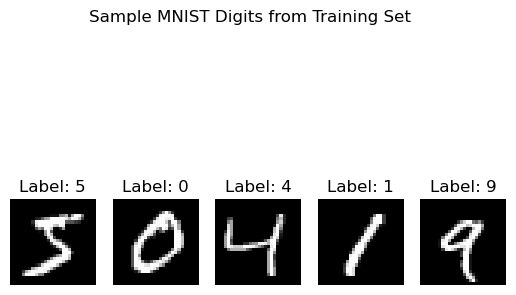

In [169]:
# Display the first 5 images with labels
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
for i in range(5):
    image, label = train_dataset[i]  # PIL image and its label
    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.suptitle("Sample MNIST Digits from Training Set")
plt.show()

In [170]:
imge, label = train_dataset[0]  # PIL image and its label
# imge = np.array(imge)
imge

### Prepare dataset

In [184]:
### config
BATCH_SIZE = 512
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
NUM_CLASSES = 2
EPOCHS = 50


In [185]:
n_train = int(len(train_dataset) * TRAIN_RATIO)
n_val = len(train_dataset) - n_train

train_data, valid_data = torch.utils.data.random_split(train_dataset, [n_train, n_val])
mean = train_data.dataset.data.float().mean() / 255.0
std = train_data.dataset.data.float().std() / 255.0

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
])

train_data.dataset.transform = train_transform
valid_data.dataset.transform = test_transform


(-0.5, 27.5, 27.5, -0.5)

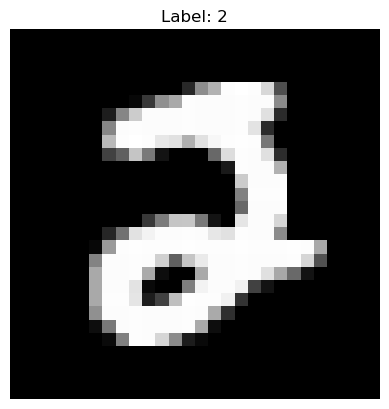

In [186]:
img, label = train_data[0]
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
plt.imshow(img[0], cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')

In [187]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [188]:
print(mean, std)

tensor(0.1307) tensor(0.3081)


In [189]:
next(iter(train_loader))[0].shape  # warm up the data loader

torch.Size([512, 1, 28, 28])

In [190]:
print(set([label for _, label in train_dataset]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### Model 

In [191]:
class TransfomerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim, dropout=0.1):
        super(TransfomerEncoder, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim, bias=True)
        )
        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x):
        # norm_1 = self.norm1(x)
        attn_output, _ = self.attn(x, x, x)
        attn_output = self.dropout1(attn_output)
        out_1 = self.norm1(x+attn_output) # skip connection
        ffn_output = self.ff(out_1)
        ffn_output = self.dropout2(ffn_output)
        out_2 = self.norm2(out_1+ffn_output)
        return out_2

In [192]:
class PatchPositionEmbedding(nn.Module): # add CLS token
    def __init__(self, embed_dim, patch_size, img_size):
        super(PatchPositionEmbedding, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = 1.0 / np.sqrt(embed_dim)
        # self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.position_embedding = nn.Parameter(scale*torch.randn((img_size // patch_size) ** 2  , embed_dim))
    def forward(self, x):
        x = self.conv1(x) # shape: (batch_size, embed_dim, h, w)
        x = x.reshape(x.shape[0], x.shape[1], -1) # shape: (batch_size, embed_dim, num_patches)
        x = x.permute(0, 2, 1) # permute to (batch_size, num_patches, embed_dim)
        # cls_embed = self.cls_token.to(x.dtype) + torch.zeros((x.shape[0], 1, x.shape[-1]), device=x.device) # shape: (batch_size, 1, embed_dim)
        # x = torch.cat((cls_embed, x), dim=1) # shape: (batch_size, num_patches + 1, embed_dim)
        x = x + self.position_embedding.to(x.dtype) # shape: (batch_size, num_patches + 1, embed_dim)
        return x
        

In [193]:
class ViT(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, ff_dim, num_classes, patch_size, drop_out, img_size=224):
        super(ViT, self).__init__()
        self.patch_embedding = PatchPositionEmbedding(embed_dim, patch_size, img_size=img_size)
        self.transformer_encoder = TransfomerEncoder(embed_dim, num_heads, num_layers, ff_dim, drop_out)
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.fc2 = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(drop_out)
    def forward(self, x):
        # take position embedding
        output = self.patch_embedding(x)
        output = self.transformer_encoder(output)
        output = output.mean(dim=1) # global average pooling
        output = self.fc1(output)
        output = self.dropout(output)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

        
        

In [194]:
samples = next(iter(train_loader))
img, label = samples[0], samples[1]
NUM_CLASSES = len(train_dataset.classes)
print(img.shape, label.shape)
model = ViT(embed_dim=512, num_heads=8, num_layers=4, ff_dim = 1024, num_classes=NUM_CLASSES, patch_size=7, drop_out=0.2, img_size=28)
from torchsummary import summary
summary(model, img.shape[1:], device='cpu')

torch.Size([512, 1, 28, 28]) torch.Size([512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 512, 4, 4]          25,088
PatchPositionEmbedding-2              [-1, 16, 512]               0
MultiheadAttention-3  [[-1, 16, 512], [-1, 2, 2]]               0
           Dropout-4              [-1, 16, 512]               0
         LayerNorm-5              [-1, 16, 512]           1,024
            Linear-6             [-1, 16, 1024]         525,312
              ReLU-7             [-1, 16, 1024]               0
            Linear-8              [-1, 16, 512]         524,800
           Dropout-9              [-1, 16, 512]               0
        LayerNorm-10              [-1, 16, 512]           1,024
TransfomerEncoder-11              [-1, 16, 512]               0
           Linear-12                  [-1, 512]         262,656
          Dropout-13                  [-1, 512]   

## Training

In [195]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    return running_loss / len(dataloader), correct / total
def evaluate(model, dataloader, optimizer, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return running_loss / len(dataloader), correct / total




In [196]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
LOG_PATH = '../model'
best_val_loss = np.inf
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(LOG_PATH, 'best_model2.pt'))
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/50, Train Loss: 1.7496, Train Acc: 0.4359, Val Loss: 1.2262, Val Acc: 0.6170
Epoch 2/50, Train Loss: 1.0143, Train Acc: 0.6834, Val Loss: 0.7090, Val Acc: 0.7868
Epoch 3/50, Train Loss: 0.6106, Train Acc: 0.8190, Val Loss: 0.4422, Val Acc: 0.8657
Epoch 4/50, Train Loss: 0.4258, Train Acc: 0.8748, Val Loss: 0.3448, Val Acc: 0.8966
Epoch 5/50, Train Loss: 0.3403, Train Acc: 0.8996, Val Loss: 0.2772, Val Acc: 0.9176
Epoch 6/50, Train Loss: 0.2946, Train Acc: 0.9129, Val Loss: 0.2504, Val Acc: 0.9229
Epoch 7/50, Train Loss: 0.2585, Train Acc: 0.9236, Val Loss: 0.2153, Val Acc: 0.9334
Epoch 8/50, Train Loss: 0.2403, Train Acc: 0.9283, Val Loss: 0.2081, Val Acc: 0.9370
Epoch 9/50, Train Loss: 0.2200, Train Acc: 0.9353, Val Loss: 0.2008, Val Acc: 0.9400
Epoch 10/50, Train Loss: 0.2020, Train Acc: 0.9399, Val Loss: 0.1690, Val Acc: 0.9480
Epoch 11/50, Train Loss: 0.1874, Train Acc: 0.9438, Val Loss: 0.1647, Val Acc: 0.9490
Epoch 12/50, Train Loss: 0.1805, Train Acc: 0.9444, Val Loss: 0

In [197]:
# testing
test_dataset.transform = test_transform
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loss, test_acc = evaluate(model, test_loader, optimizer, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Test Loss: 0.1275, Test Acc: 0.9631


In [198]:
enhance_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
train_data.dataset.transform = enhance_transform
best_val_loss = np.inf
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, valid_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(LOG_PATH, 'model_withnoise.pt'))
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/50, Train Loss: 1.2648, Train Acc: 0.5873, Val Loss: 0.8598, Val Acc: 0.7027
Epoch 2/50, Train Loss: 0.8564, Train Acc: 0.7058, Val Loss: 0.7358, Val Acc: 0.7456
Epoch 3/50, Train Loss: 0.7645, Train Acc: 0.7370, Val Loss: 0.7316, Val Acc: 0.7483
Epoch 4/50, Train Loss: 0.7126, Train Acc: 0.7545, Val Loss: 0.6425, Val Acc: 0.7824
Epoch 5/50, Train Loss: 0.6671, Train Acc: 0.7727, Val Loss: 0.5973, Val Acc: 0.7973
Epoch 6/50, Train Loss: 0.6319, Train Acc: 0.7849, Val Loss: 0.5604, Val Acc: 0.8063
Epoch 7/50, Train Loss: 0.6128, Train Acc: 0.7917, Val Loss: 0.5391, Val Acc: 0.8147
Epoch 8/50, Train Loss: 0.5848, Train Acc: 0.8020, Val Loss: 0.5044, Val Acc: 0.8257
Epoch 9/50, Train Loss: 0.5630, Train Acc: 0.8107, Val Loss: 0.5170, Val Acc: 0.8208
Epoch 10/50, Train Loss: 0.5587, Train Acc: 0.8102, Val Loss: 0.4815, Val Acc: 0.8297
Epoch 11/50, Train Loss: 0.5274, Train Acc: 0.8203, Val Loss: 0.4742, Val Acc: 0.8363
Epoch 12/50, Train Loss: 0.5169, Train Acc: 0.8255, Val Loss: 0

In [121]:
torch.save(model.state_dict(), os.path.join(LOG_PATH, 'model_with_noisedata.pt'))

In [123]:
test_dataset.transform = test_transform
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) 
test_loss, test_acc = evaluate(model, test_loader, optimizer, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.3663, Test Acc: 0.8765


In [132]:
model1 = ViT(embed_dim=512, num_heads=4, num_layers=4, ff_dim = 1024, num_classes=NUM_CLASSES, patch_size=7, drop_out=0.1, img_size=28)
model1.load_state_dict(torch.load(os.path.join(LOG_PATH, 'best_model.pt')))
model1 = model1.to(device)
test_loss, test_acc = evaluate(model1, test_loader, optimizer, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

C:\Users\PC\AppData\Local\Temp\ipykernel_11104\687143408.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(os.path.join(LOG_PATH, 'best_m

Test Loss: 0.1610, Test Acc: 0.9547


In [133]:
test_dataset.transform = enhance_transform
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loss, test_acc = evaluate(model1, test_loader, optimizer, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 4.7081, Test Acc: 0.2876


In [135]:
model1.load_state_dict(torch.load(os.path.join(LOG_PATH, 'model_with_noisedata.pt')))
model1 = model1.to(device)
test_loss, test_acc = evaluate(model1, test_loader, optimizer, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

C:\Users\PC\AppData\Local\Temp\ipykernel_11104\1008609239.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(os.path.join(LOG_PATH, 'model

Test Loss: 0.4529, Test Acc: 0.8458


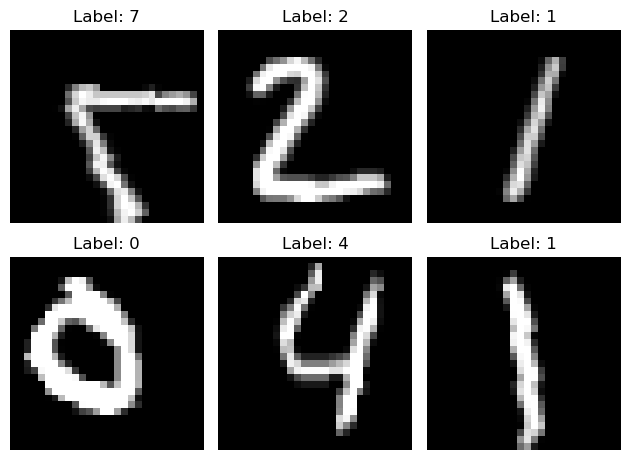

In [138]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Get one batch from the test_loader
images, labels = next(iter(test_loader))

# Plot some of them
for i in range(6):  # Show 6 samples
    img = images[i]
    img = img * std + mean  # de-normalize
    
    img = img.squeeze(0) if img.shape[0] == 1 else img  # remove channel dim if grayscale
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(img.numpy(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [144]:
model.load_state_dict(torch.load(os.path.join(LOG_PATH, 'best_model.pt')))
model = model.to(device)
samples = next(iter(test_loader))
img, label = samples[0], samples[1]
model

C:\Users\PC\AppData\Local\Temp\ipykernel_11104\2482364135.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(LOG_PATH, 'best_m

ViT(
  (patch_embedding): PatchPositionEmbedding(
    (conv1): Conv2d(1, 512, kernel_size=(7, 7), stride=(7, 7), bias=False)
  )
  (transformer_encoder): TransfomerEncoder(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (ff): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
    )
    (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [147]:
with torch.no_grad():
    img = img.to(device)
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    print(predicted)
    print(label)

tensor([7, 3, 1, 7, 1, 1, 1, 3, 5, 7, 3, 3, 5, 8, 1, 3, 3, 1, 3, 5, 7, 1, 1, 3,
        7, 0, 1, 7, 7, 1, 5, 1, 5, 1, 5, 3, 1, 1, 3, 1, 1, 7, 1, 2, 1, 5, 1, 5,
        5, 4, 3, 5, 1, 3, 7, 4, 1, 1, 7, 3, 3, 3, 3, 3, 3, 1, 4, 1, 3, 3, 3, 0,
        2, 1, 1, 5, 5, 5, 7, 7, 7, 6, 2, 7, 8, 1, 3, 5, 7, 1, 7, 1, 3, 1, 1, 8,
        1, 2, 2, 8, 3, 5, 3, 1, 3, 3, 2, 1, 3, 3, 8, 7, 3, 1, 3, 1, 1, 7, 3, 5,
        2, 1, 1, 1, 3, 5, 3, 3, 8, 3, 2, 1, 5, 2, 3, 1, 1, 1, 5, 1, 3, 7, 5, 1,
        3, 1, 7, 5, 1, 3, 3, 3, 3, 2, 1, 5, 1, 4, 3, 1, 1, 3, 3, 7, 1, 3, 2, 3,
        1, 1, 1, 3, 2, 3, 2, 3, 1, 1, 1, 3, 1, 3, 3, 7, 2, 2, 5, 3, 7, 1, 1, 1,
        3, 3, 0, 3, 1, 2, 1, 2, 5, 3, 1, 1, 1, 5, 1, 3, 3, 7, 1, 5, 6, 5, 9, 1,
        3, 5, 3, 3, 7, 7, 8, 7, 1, 3, 1, 1, 1, 5, 3, 3, 3, 8, 3, 7, 3, 3, 1, 1,
        3, 5, 3, 3, 1, 3, 3, 1, 7, 5, 8, 1, 8, 5, 5, 1, 2, 1, 2, 5, 8, 7, 3, 1,
        1, 1, 8, 1, 3, 5, 3, 7, 1, 8, 8, 4, 1, 8, 3, 1, 3, 8, 1, 3, 3, 5, 1, 7,
        1, 3, 8, 3, 1, 3, 1, 1, 0, 3, 3,

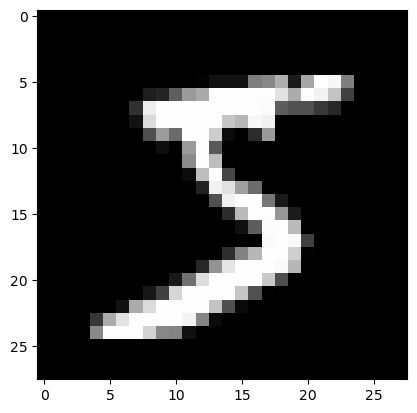

In [24]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
sample = train_dataset[0][0]  # a tensor
plt.imshow(sample.squeeze(), cmap='gray')
plt.show()